#AI VIET NAM
#Naive Object Detection

**Import Libs**

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt
import matplotlib.patches as patches

**Download Sample**

In [ ]:
!gdown 1cEdEmTaHkKCY5ayeNugHTgWe-XEzHwlD
!unzip ./sample.zip

Downloading...
From: https://drive.google.com/uc?id=1cEdEmTaHkKCY5ayeNugHTgWe-XEzHwlD
To: /content/sample.zip
100% 558k/558k [00:00<00:00, 78.9MB/s]
Archive:  ./sample.zip
   creating: sample/
  inflating: __MACOSX/._sample       
  inflating: sample/.DS_Store        
  inflating: __MACOSX/sample/._.DS_Store  
  inflating: sample/imagenet1000_clsid_to_human.pkl  
  inflating: __MACOSX/sample/._imagenet1000_clsid_to_human.pkl  
  inflating: sample/dog.jpeg         
  inflating: __MACOSX/sample/._dog.jpeg  
  inflating: sample/pets.jpeg        
  inflating: __MACOSX/sample/._pets.jpeg  


##**1. Single Object**

###**1.1. Basic Classification**

In [ ]:
dog_image = Image.open("./sample/dog.jpeg")

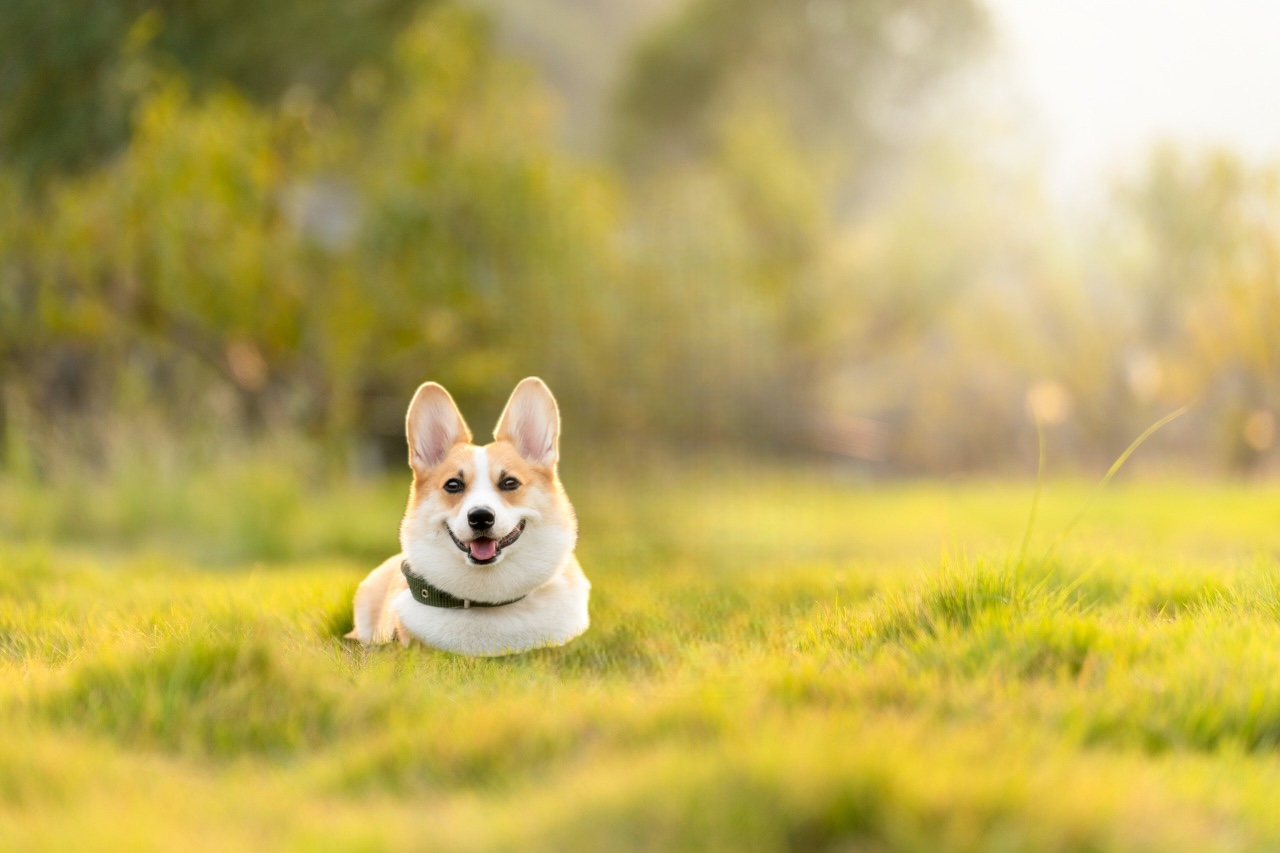

In [ ]:
dog_image

In [ ]:
IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2471, 0.2435, 0.2616]
    ),
])

In [ ]:
model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
labels = np.load('./sample/imagenet1000_clsid_to_human.pkl', allow_pickle=True)
labels[1]

'goldfish, Carassius auratus'

In [ ]:
def predict(img):
    # Preprocess image
    preprocess_img = transform(img)
    preprocess_img = preprocess_img.unsqueeze(0)
    preprocess_img = preprocess_img.to(device)

    # Predict
    with torch.no_grad():
        output = model(preprocess_img)

    output = torch.nn.functional.softmax(output, dim=-1)

    prediction = output.argmax(1)
    prob = output[0][prediction].item()

    # Convert idx to label
    label = labels[prediction.item()]
    return prob, label

In [ ]:
prob, label = predict(dog_image)
prob, label

(0.450310617685318, 'Pembroke, Pembroke Welsh corgi')

###**1.2. Naive Object Detection using Sliding Window**

In [ ]:
np.array(dog_image).shape

(853, 1280, 3)

In [ ]:
def slide_image(img, patch_size=224, step=30):
    # Convert PIL image to numpy array
    np_image = np.array(img)
    h, w, _ = np_image.shape
    patches = []

    # Iterate over the large image
    for y in range(0, h-patch_size+1, step):
        for x in range(0, w-patch_size+1, step):
            # Extract patch
            patch = np_image[y:y+patch_size, x:x+patch_size, :]
            patch = Image.fromarray(patch)
            patches.append({
                'x': x,
                'y': y,
                'image': patch
            })

    return patches

In [ ]:
image_patches = slide_image(dog_image)

In [ ]:
len(image_patches)

756

In [ ]:
image_patches[0]

{'x': 0, 'y': 0, 'image': <PIL.Image.Image image mode=RGB size=224x224>}

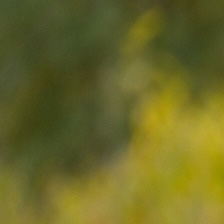

In [ ]:
image_patches[0]['image']

In [ ]:
prob, label = predict(image_patches[0]['image'])
prob, label

(0.04727791249752045, 'bee eater')

In [ ]:
for idx in tqdm(range(len(image_patches))):
    prob, label = predict(image_patches[idx]['image'])
    image_patches[idx].update({
        'prob': prob,
        'label': label
    })

100%|██████████| 756/756 [01:16<00:00,  9.84it/s]


In [ ]:
image_patches[0]

{'x': 0,
 'y': 0,
 'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'prob': 0.04727791249752045,
 'label': 'bee eater'}

In [ ]:
sorted_image_patches = sorted(image_patches, key=lambda x: x['prob'] , reverse=True)

In [ ]:
sorted_image_patches[0]

{'x': 330,
 'y': 300,
 'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'prob': 0.9692906737327576,
 'label': 'Pembroke, Pembroke Welsh corgi'}

In [ ]:
sorted_image_patches[1]

{'x': 360,
 'y': 300,
 'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'prob': 0.9677960276603699,
 'label': 'Pembroke, Pembroke Welsh corgi'}

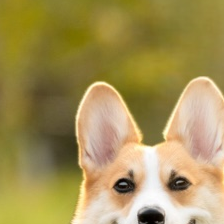

In [ ]:
sorted_image_patches[0]['image']

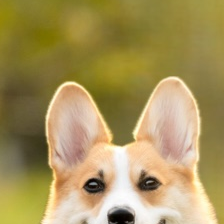

In [ ]:
sorted_image_patches[1]['image']

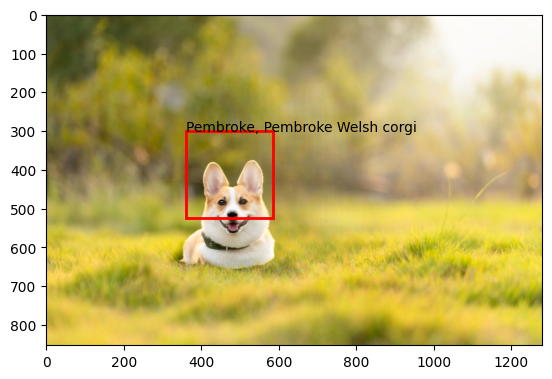

In [ ]:
idx = 1

fig, ax = plt.subplots()
ax.imshow(dog_image)

# Create a Rectangle patch
rect = patches.Rectangle(
    (sorted_image_patches[idx]['x'], sorted_image_patches[idx]['y']),
    224, 224, linewidth=2, edgecolor='r', facecolor='none'
)
ax.add_patch(rect)
plt.text(
    sorted_image_patches[idx]['x'],
    sorted_image_patches[idx]['y'],
    sorted_image_patches[idx]['label']
)

plt.show()

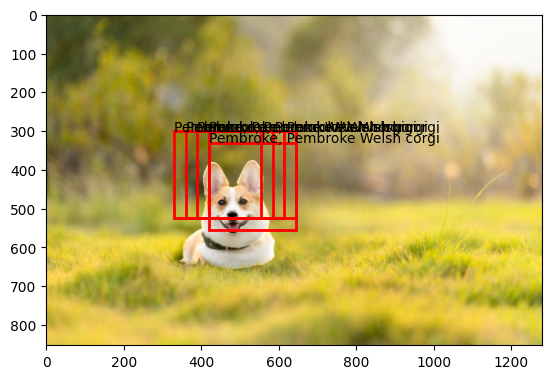

In [ ]:
fig, ax = plt.subplots()
ax.imshow(dog_image)
for idx in range(5):
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (sorted_image_patches[idx]['x'], sorted_image_patches[idx]['y']),
        224, 224, linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    plt.text(
        sorted_image_patches[idx]['x'],
        sorted_image_patches[idx]['y'],
        sorted_image_patches[idx]['label']
    )

plt.show()

##**2. Multi Objects**

In [ ]:
pets_image = Image.open("./sample/pets.jpeg")

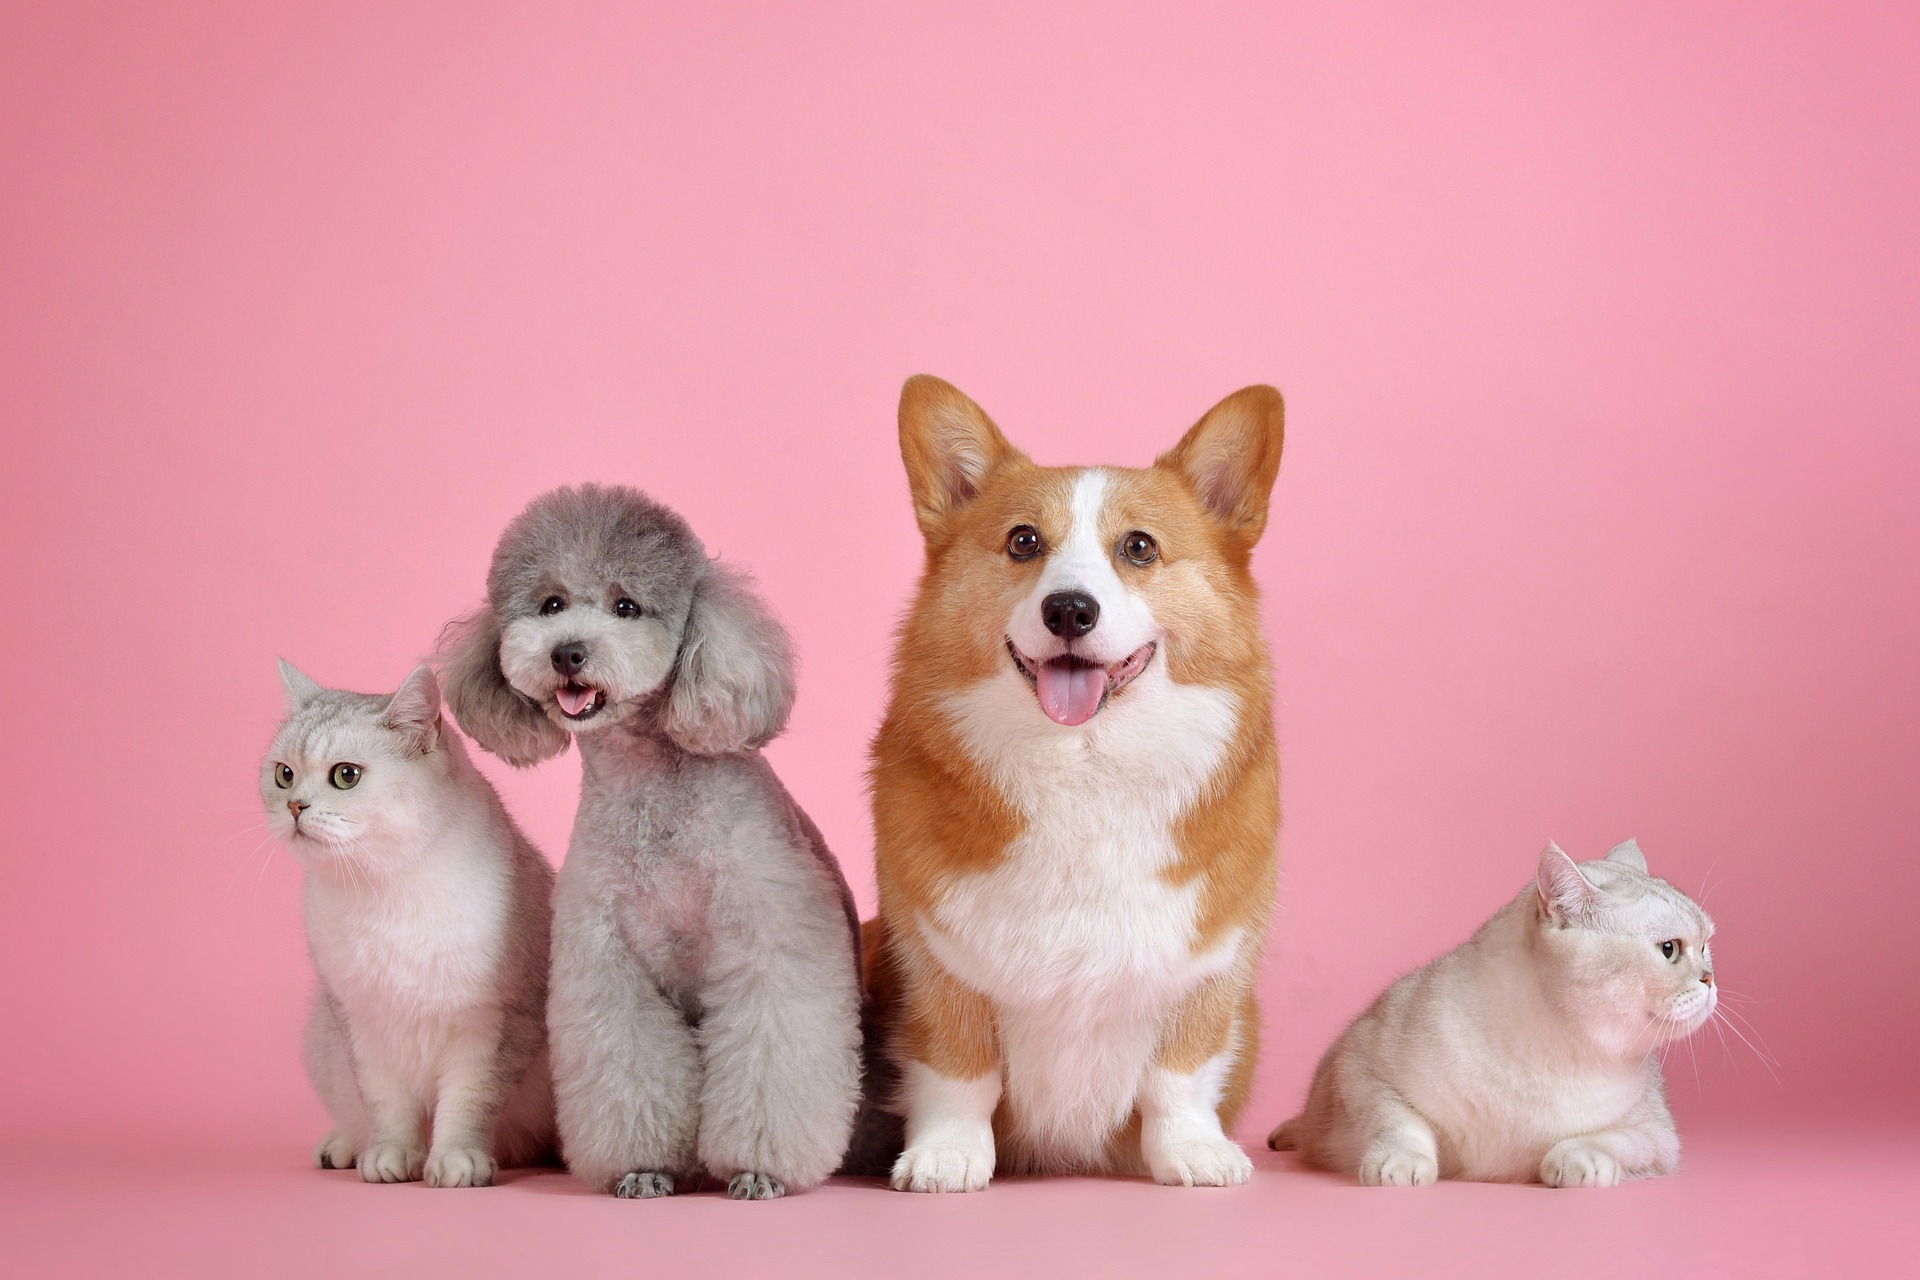

In [ ]:
pets_image

In [ ]:
image_patches = slide_image(pets_image)

In [ ]:
for idx in tqdm(range(len(image_patches))):
    prob, label = predict(image_patches[idx]['image'])
    image_patches[idx].update({
        'prob': prob,
        'label': label
    })

100%|██████████| 2052/2052 [03:30<00:00,  9.74it/s]


In [ ]:
len(image_patches)

2052

In [ ]:
sorted_image_patches = sorted(image_patches, key=lambda x: x['prob'] , reverse=True)

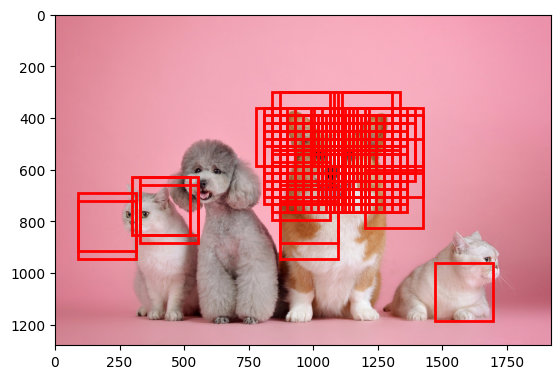

In [ ]:
fig, ax = plt.subplots()
ax.imshow(pets_image)
for idx in range(100):
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (sorted_image_patches[idx]['x'], sorted_image_patches[idx]['y']),
        224, 224, linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    # plt.text(
    #     sorted_image_patches[idx]['x'],
    #     sorted_image_patches[idx]['y'],
    #     sorted_image_patches[idx]['label']
    # )

plt.show()

### **2.1. Is there any way to calculate the intersection between boxes?**

In [ ]:
def distance(x1, y1, x2, y2):
    return np.sqrt((y1 - y2) ** 2 + (x2 - y2) ** 2)

Pros:
- Simple
- Easy to implement

Cons:
- Don't know what is close enough
- Does not work well when the bounding box shape vary

In [ ]:
def iou(x1, y1, x2, y2, box_shape=224):
    # Extract the coordinates of the two boxes
    x1_min, y1_min, x1_max, y1_max = x1, y1, x1 + box_shape, y1 + box_shape
    x2_min, y2_min, x2_max, y2_max = x2, y2, x2 + box_shape, y2 + box_shape

    # Calculate the coordinates of the intersection rectangle
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    # Calculate the area of the intersection rectangle
    inter_area = max(0, x_inter_max - x_inter_min) * max(0, y_inter_max - y_inter_min)

    # Calculate the area of both rectangles
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the union area
    union_area = box1_area + box2_area - inter_area

    # Calculate the IoU
    iou = inter_area / union_area

    return iou

### **2.2. Filter algorithm**

In [ ]:
def filter_function(sorted_image_patches, iou_threshold = 0.4, distance_func=iou):
    keep = []
    order = sorted_image_patches.copy()
    order = [item for item in order if item['prob'] > 0.8]
    while len(order) > 0:
        patch = order[0]
        keep.append(patch)

        order = order[1:]

        if len(order) == 0:
            break

        for idx, other_patch in enumerate(order):
            iou_score = distance_func(patch['x'], patch['y'], other_patch['x'], other_patch['y'])
            if iou_score > iou_threshold:
                order[idx] = None
        order = [item for item in order if item is not None]
    return keep


In [ ]:
keep = filter_function(sorted_image_patches, iou_threshold=0.35, distance_func=iou)

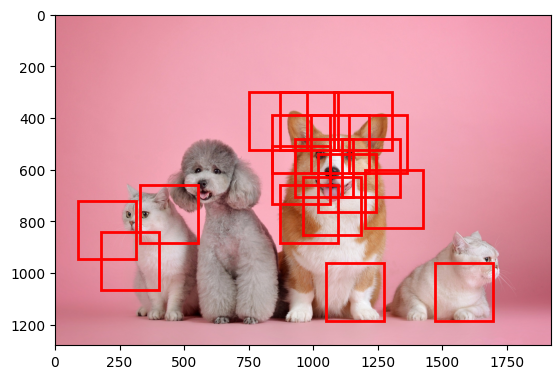

In [ ]:
fig, ax = plt.subplots()
ax.imshow(pets_image)
for idx in range(len(keep)):
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (keep[idx]['x'], keep[idx]['y']),
        224, 224, linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    # plt.text(
    #     sorted_image_patches[idx]['x'],
    #     sorted_image_patches[idx]['y'],
    #     sorted_image_patches[idx]['label']
    # )

plt.show()